# MNIST Example with Data Logging in DataFed


## Import Libraries


In [1]:
import os
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from m3util.util.IO import make_folder
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

sys.path.append(os.path.abspath("/home/jg3837/DataFed_TorchFlow/DataFed_TorchFlow/src"))
from datafed_torchflow.pytorch import TorchLogger

## Paramters to Update


## Builds the CNN


In [2]:
# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding=1
        )

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # Output layer for 10 classes (digits 0-9)

    def forward(self, x):
        # Apply convolutional layers with ReLU and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the output
        x = x.view(-1, 64 * 7 * 7)

        # Apply fully connected layers with ReLU and final output
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

## Define transformations for data preprocessing


In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize(
            (0.1307,), (0.3081,)
        ),  # Normalize with mean and std of MNIST dataset
    ]
)

## Load the MNIST dataset


In [4]:
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

In [13]:
train_loader.dataset[0][0].shape

torch.Size([1, 28, 28])

## Instantiate the model, loss function, and optimizer, and DataFed TorchLogger


In [5]:
suffix = "101024"
notebook_path = "./PytorchModelLogger.ipynb"


criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification

learning_rate = 0.001
optimizer = optim.Adam(SimpleCNN().parameters(), lr=learning_rate)  # Adam optimizer

model_dict = {"model": SimpleCNN(), "optimizer": optimizer}

In [6]:
torchlogger = TorchLogger(
    model_dict=model_dict,
    DataFed_path=f"2024_test_pytorch/delete_me/{suffix}",
    script_path=notebook_path,
    input_data_shape=train_dataset[0][0].shape,
    dataset_id_or_path=[file.path for file in os.scandir("./data/MNIST/raw")],
    local_model_path=f"examples/model/{suffix}",
    logging=True,
)

Unable to connect to pypi: <Fault -32500: 'RuntimeError: PyPI no longer supports the XMLRPC package_releases method. Use JSON or Simple API instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.'>


## Training function

This function calls TorchLogger.save, which does the following:

1. Saves the model checkpoint
1. Identifies the approprate metadata for the model (including DataFed provenance dependencies)
1. Identifies and navigates to the approprate DataFed project and collection
1. Creates a DataFed data record with this metadata
1. Saves the model weights file or, gets the local zip file the user specified instead in order to upload multiple files to the same DataFed data record
1. Uploads the zip file to the DataFed data record generated in the previous steps


In [7]:
def train(
    model,
    device,
    train_loader,
    optimizer,
    criterion,
    epoch,
    base_local_file_name,
    local_vars,
):
    make_folder(base_local_file_name)  # ensure the path exists to save the weights

    model.train()  # Set the model to training mode

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                f"({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}"
            )

    file_name = f"MNSIT_epoch_{epoch}_loss_{loss.item():.4e}"
    local_file_path = f"{base_local_file_name}/{file_name}.pkl"

    torchlogger.save(
        file_name,
        epoch=epoch,
        # training_loss=loss.item(),
        local_file_path=local_file_path,
        local_vars=local_vars,
        model_hyperparameters={"learning_rate": learning_rate},
    )

## Testing function


In [8]:
def test(model, device, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            test_loss += criterion(output, target).item()  # Sum up the batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)

    print(
        f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} "
        f"({accuracy:.2f}%)\n"
    )

## Instantiate the DataFed Configuration


## Train Model


In [9]:
model = SimpleCNN()

In [10]:
# Train and test the CNN
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [11]:
n_epochs = 5
for epoch in range(1, n_epochs + 1):
    local_vars = locals()

    train(
        model=model,
        device=device,
        train_loader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        epoch=epoch,
        base_local_file_name="model/100124/weights",
        local_vars=list(local_vars.items()),
    )
    test(model=model, device=device, test_loader=test_loader, criterion=criterion)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.329736
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.323759
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.267824
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.332277
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.309857
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.312216
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.337153
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.301441
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.289233
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.306317

Test set: Average loss: 0.0023, Accuracy: 898/10000 (8.98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.312785
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.320899
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.299239
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.303957
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.303349
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.307781
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.305706
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.317954
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.317648


In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [42]:
embeddings_test = np.array(
    [
        0.0,
        0.081245735,
        2.3474283,
        1.0907413,
        0.38644513,
        0.5354103,
        0.24752855,
        1.5337979,
        0.79200786,
        0.86353016,
        0.5373011,
        0.5339184,
        1.7451648,
        0.09865524,
        0.0,
        0.0,
        0.27771732,
        0.55278724,
        0.8063575,
        0.0,
        0.44164205,
        0.0,
        0.5163624,
        0.0,
        1.2978721,
        0.0,
        1.366137,
        0.0,
        2.2715738,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.76496065,
        1.021282,
        0.81363803,
        0.86824065,
        0.0,
        1.0070741,
        0.31274152,
        0.590073,
        0.0,
        0.99915546,
        0.28702337,
        0.77693,
        1.0281565,
        1.1779579,
        1.7272567,
        0.53295076,
        1.0039914,
        0.0,
        1.5707381,
        0.0,
        0.0,
    ]
)

In [55]:
np.append(embeddings_test, embeddings_test).shape

(120,)

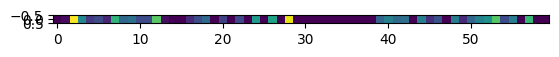

In [47]:
plt.imshow(embeddings_test.reshape(1, -1))

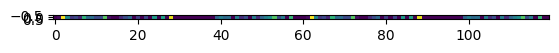

In [58]:
plt.imshow(np.expand_dims(np.append(embeddings_test, embeddings_test), 0))

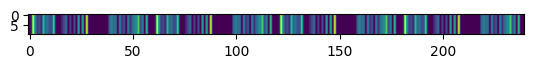

In [61]:
plt.imshow(np.tile(embeddings_test, (10, 4)))

In [62]:
np.tile(embeddings_test, (10, 4)).shape

(10, 240)

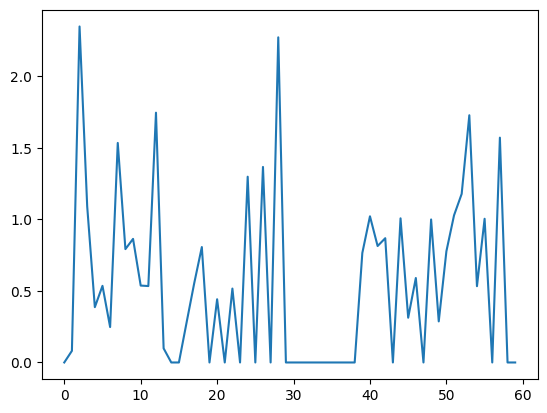

In [46]:
plt.plot(embeddings_test)

In [2]:
testing = np.array(
    [
        -6.9418e-12,
        -9.8875e-12,
        -1.3140e-11,
        -1.6038e-11,
        -1.7288e-11,
        -1.4666e-11,
        -4.6715e-12,
        1.7822e-11,
        5.9803e-11,
        1.3009e-10,
        2.3875e-10,
        3.9565e-10,
        6.0755e-10,
        8.7330e-10,
        1.1764e-09,
        1.4747e-09,
        1.6864e-09,
        1.6738e-09,
        1.2257e-09,
        4.1601e-11,
        -2.2767e-09,
        -6.2176e-09,
        -1.2324e-08,
        -2.1119e-08,
        -3.2963e-08,
        -4.7847e-08,
        -6.5080e-08,
        -8.2880e-08,
        -9.7880e-08,
        -1.0457e-07,
        -9.4769e-08,
        -5.7215e-08,
        2.2491e-08,
        1.6138e-07,
        3.7773e-07,
        6.8842e-07,
        1.1047e-06,
        1.6261e-06,
        2.2321e-06,
        2.8727e-06,
        3.4566e-06,
        3.8404e-06,
        3.8194e-06,
        3.1233e-06,
        1.4208e-06,
        -1.6629e-06,
        -6.5107e-06,
        -1.3455e-05,
        -2.2696e-05,
        -3.4187e-05,
        -4.7501e-05,
        -6.1686e-05,
        -7.5106e-05,
        -8.5322e-05,
        -8.9018e-05,
        -8.2025e-05,
        -5.9485e-05,
        -1.6196e-05,
        5.2820e-05,
        1.5151e-04,
        2.8172e-04,
        4.4199e-04,
        6.2611e-04,
        8.2186e-04,
        1.0098e-03,
        1.1629e-03,
        1.2461e-03,
        1.2181e-03,
        1.0335e-03,
        6.4694e-04,
        1.8769e-05,
        -8.7808e-04,
        -2.0498e-03,
        -3.4732e-03,
        -5.0876e-03,
        -6.7881e-03,
        -8.4228e-03,
        -9.7930e-03,
        -1.0661e-02,
        -1.0763e-02,
        -9.8291e-03,
        -7.6145e-03,
        -3.9297e-03,
        1.3205e-03,
        8.0994e-03,
        1.6205e-02,
        2.5247e-02,
        3.4631e-02,
        4.3575e-02,
        5.1133e-02,
        5.6253e-02,
        5.7860e-02,
        5.4951e-02,
        4.6716e-02,
        3.2656e-02,
        1.2699e-02,
        -1.2704e-02,
        -4.2521e-02,
        -7.5120e-02,
        -1.0831e-01,
        -1.3946e-01,
        -1.6565e-01,
        -1.8388e-01,
        -1.9138e-01,
        -1.8585e-01,
        -1.6575e-01,
        -1.3056e-01,
        -8.0936e-02,
        -1.8838e-02,
        5.2515e-02,
        1.2876e-01,
        2.0467e-01,
        2.7449e-01,
        3.3238e-01,
        3.7296e-01,
        3.9173e-01,
        3.8561e-01,
        3.5321e-01,
        2.9514e-01,
        2.1406e-01,
        1.1454e-01,
        2.8408e-03,
        -1.1360e-01,
        -2.2670e-01,
        -3.2836e-01,
        -4.1115e-01,
        -4.6894e-01,
        -4.9739e-01,
        -4.9435e-01,
        -4.6003e-01,
        -3.9699e-01,
        -3.0992e-01,
        -2.0524e-01,
        -9.0541e-02,
        2.6008e-02,
        1.3636e-01,
        2.3323e-01,
        3.1060e-01,
        3.6420e-01,
        3.9172e-01,
        3.9293e-01,
        3.6952e-01,
        3.2490e-01,
        2.6377e-01,
        1.9169e-01,
        1.1454e-01,
        3.8076e-02,
        -3.2562e-02,
        -9.3160e-02,
        -1.4069e-01,
        -1.7340e-01,
        -1.9086e-01,
        -1.9378e-01,
        -1.8388e-01,
        -1.6360e-01,
        -1.3581e-01,
        -1.0353e-01,
        -6.9712e-02,
        -3.6942e-02,
        -7.3498e-03,
        1.7515e-02,
        3.6711e-02,
        4.9881e-02,
        5.7184e-02,
        5.9193e-02,
        5.6776e-02,
        5.0977e-02,
        4.2894e-02,
        3.3586e-02,
        2.3990e-02,
        1.4873e-02,
        6.8035e-03,
        1.4423e-04,
        -4.9307e-03,
        -8.4108e-03,
        -1.0414e-02,
        -1.1146e-02,
        -1.0867e-02,
        -9.8532e-03,
        -8.3713e-03,
        -6.6592e-03,
        -4.9124e-03,
        -3.2782e-03,
        -1.8558e-03,
        -6.9982e-04,
        1.7184e-04,
        7.7017e-04,
        1.1260e-03,
        1.2818e-03,
        1.2848e-03,
        1.1813e-03,
        1.0129e-03,
        8.1430e-04,
        6.1202e-04,
        4.2473e-04,
        2.6385e-04,
        1.3477e-04,
        3.8297e-05,
        -2.7996e-05,
        -6.8469e-05,
        -8.8388e-05,
        -9.3126e-05,
        -8.7620e-05,
        -7.6047e-05,
        -6.1686e-05,
        -4.6914e-05,
        -3.3290e-05,
        -2.1695e-05,
        -1.2487e-05,
        -5.6564e-06,
        -9.6199e-07,
        1.9597e-06,
        3.5111e-06,
        4.0781e-06,
        3.9964e-06,
        3.5362e-06,
        2.8994e-06,
        2.2253e-06,
        1.6007e-06,
        1.0714e-06,
        6.5416e-07,
        3.4669e-07,
        1.3556e-07,
        2.4567e-09,
        -7.1789e-08,
        -1.0468e-07,
        -1.1079e-07,
        -1.0137e-07,
        -8.4484e-08,
        -6.5480e-08,
        -4.7555e-08,
        -3.2337e-08,
        -2.0391e-08,
        -1.1632e-08,
        -5.6289e-09,
        -1.8145e-09,
        3.8087e-10,
        1.4592e-09,
        1.8237e-09,
        1.7747e-09,
        1.5206e-09,
        1.1951e-09,
        8.7597e-10,
        6.0196e-10,
        3.8674e-10,
        2.2943e-10,
        1.2183e-10,
        5.3197e-11,
        1.2922e-11,
        -8.0748e-12,
        -1.6881e-11,
        -1.8629e-11,
        -1.6778e-11,
        -1.3494e-11,
        -1.0011e-11,
        -6.9418e-12,
    ]
)

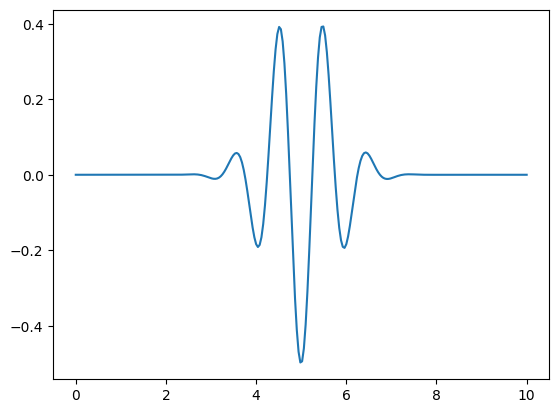

In [33]:
plt.plot(np.linspace(0, 10, 256), testing)

In [5]:
testing2 = np.load(
    "/home/jg3837/Transformer_Beta_VAE/src/transformer_beta_vae/Transformer_VAE/Gaussians/Combined_Gaussian_dataset.npy"
)

In [12]:
testing2[:, 0].shape

(384,)

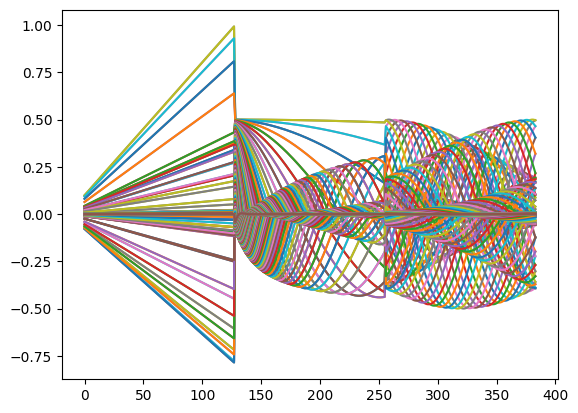

In [9]:
plt.plot(testing2)

In [21]:
testing.shape

(256,)

In [29]:
np.min(
    np.vstack([testing, np.linspace(0, 10, 256)])
    == np.stack((testing, np.linspace(0, 10, 256)))
)

True

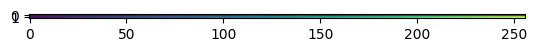

In [32]:
plt.imshow(np.vstack([testing, np.linspace(0, 10, 256)]))